<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico </h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import scipy
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency

In [2]:
seaborn.__version__

'0.10.1'

In [3]:
BLUE = '#35A7FF'
RED = '#FF5964'
GREEN = '#6BF178'
YELLOW = '#FFE74C'

In [4]:
# Con esto hacemos los gráficos más grandes, adecuados para las presentaciones.
seaborn.set_context(context='talk', font_scale=1.2)

Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [5]:
dataset_base = pandas.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset_base.shape

(1620, 120)

In [6]:
dataset_base.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'hf_score', 'hf_rank',
       'hf_quartile', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
       ...
       'ef_regulation_business_adm', 'ef_regulation_business_bureaucracy',
       'ef_regulation_business_start', 'ef_regulation_business_bribes',
       'ef_regulation_business_licensing', 'ef_regulation_business_compliance',
       'ef_regulation_business', 'ef_regulation', 'ef_score', 'ef_rank'],
      dtype='object', length=120)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [7]:
score_cols = [col for col in dataset_base.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [8]:
dataset_base[important_cols].head()

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0,10,10,10,7.5,5.8,8.01,46,7.67,30,7.84,38
1,2017,DZA,Algeria,Middle East & North Africa,-,0,0,0,0,0,5.2,146,4.77,159,4.99,155
2,2017,AGO,Angola,Sub-Saharan Africa,10,0,0,0,5,5,5.98,121,4.83,158,5.4,151
3,2017,ARG,Argentina,Latin America & the Caribbean,10,10,10,10,10,10,8.04,41,5.67,147,6.86,77
4,2017,ARM,Armenia,Caucasus & Central Asia,7,10,10,10,7.5,8.2,7.15,72,7.7,27,7.42,54


Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [9]:
dataset_base = dataset_base[important_cols].replace('-', numpy.nan)
for score_col in score_cols:
    dataset_base[score_col] = pandas.to_numeric(dataset_base[score_col])
dataset_base.head()

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0


# Parte 1

Luego de las clases del primer fin de semana, ya tenemos las herramientas para responder las siguientes preguntas:

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.

In [10]:
dataset_base = dataset_base.replace('Latin America & the Caribbean','LatAm')
pandas.to_numeric(dataset_base.year, downcast='integer')
dataset_base['year'] = pandas.to_numeric(dataset_base['year'], downcast='integer')
df = dataset_base
df = df.drop(['ISO_code', 'countries', 'region'], axis=1)# drop non numeric variables
max_row = df.max()
min_row = df.min()
min_row[0] = min_row[0].astype('int32')
max_row[0] = max_row[0].astype('int32')
ranges = max_row - min_row
range_df = pandas.DataFrame({'Min' : min_row,'Max' : max_row, "Range" : ranges})
round(range_df,2)

,Min,Max,Range
year,2008.00,2017.00,9.00
pf_identity_legal,0.00,10.00,10.00
pf_identity_sex_male,0.00,10.00,10.00
pf_identity_sex_female,0.00,10.00,10.00
pf_identity_sex,0.00,10.00,10.00
pf_identity_divorce,0.00,10.00,10.00
pf_identity,0.00,10.00,10.00
pf_score,2.22,9.56,7.34
pf_rank,1.00,162.00,161.00
ef_score,2.58,9.11,6.53


Para sacar conclusiones decidimos usar principalmente los promedios (mean) porque, entre las medidas de tendencia central, el *mean* es el estimador que incluye todos los datos. Eso no es el caso con la mediana.


2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no. Eso no es el caso con la mediana.

In [11]:
datos1=dataset_base[dataset_base.year==2017] # eligimos datos del año 2017

In [12]:
# Create a subset for latin america and the carribean
grouped = datos1.groupby(['region'])
LatAm = grouped.get_group('LatAm')

In [13]:
descriptive_df = pandas.DataFrame({'index' : ['pf_identity_mean','pf_identity_std','pf_identity_median', \
                                              'hf_score_mean','hf_score_std','hf_score_median'], \
                                   'LatAm' : [ LatAm.pf_identity.mean(), \
                                              LatAm.pf_identity.std(), \
                                              LatAm.pf_identity.median(), \
                                              LatAm.hf_score.mean(), \
                                              LatAm.hf_score.std(), \
                                              LatAm.hf_score.median()], \
                                   "World" : [ datos1.pf_identity.mean(), \
                                              datos1.pf_identity.std(), \
                                              datos1.pf_identity.median(), \
                                              datos1.hf_score.mean(), \
                                              datos1.hf_score.std(), \
                                              datos1.hf_score.median()]})
round(descriptive_df.set_index('index'),2) # make it a little prettier

,LatAm,World
index,,
pf_identity_mean,7.40,6.50
pf_identity_std,1.99,3.15
pf_identity_median,6.70,7.50
hf_score_mean,6.95,6.89
hf_score_std,0.77,1.10
hf_score_median,6.92,6.82


*¿Tiene sentido calcular la moda?* 
**No tiene mucho sentido calcular la moda porque no es muy relevante si se repita un valor en ninguna de las variables.**

*¿Cómo pueden sanearse los valores faltantes?*
**Por suerte, en pandas, cuando hay un valor faltante, osea un ```None```, no le incluye en el promedio. Todos los valores faltantes estan reemplazados por ```None```.** 

*¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?* 
**Usamos la regla de 1.5 * IQR (interquartile range) para identificar outliers.**

## OUTLIERS con 1.5*IQR

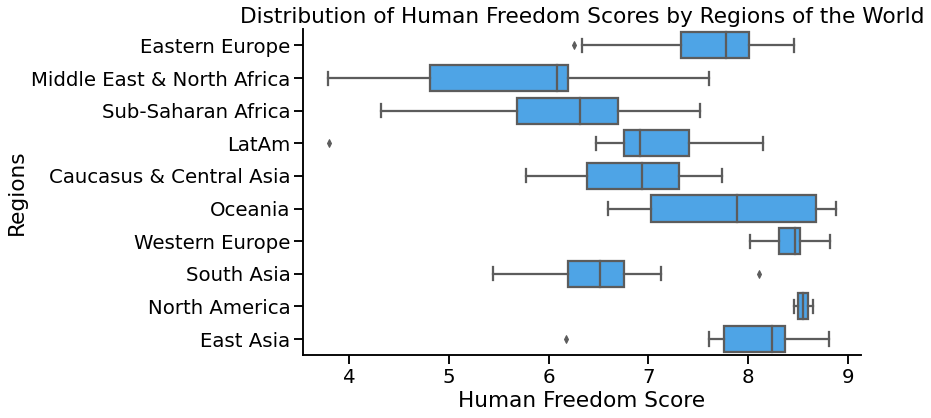

In [14]:
# The best way to quickly visualize outliers is with the box and whiskers plot (grafico de caja)
plt.figure(figsize=(10,6))
seaborn.boxplot(data=datos1,
                x='hf_score', y= 'region',
                color=BLUE)
plt.ylabel('Regions')
plt.xlabel('Human Freedom Score')
plt.title('Distribution of Human Freedom Scores by Regions of the World')
seaborn.despine()

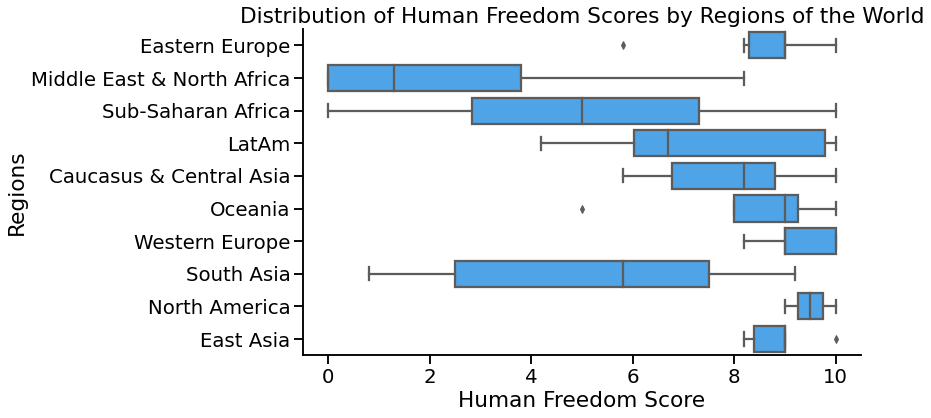

In [15]:
plt.figure(figsize=(10,6))
seaborn.boxplot(data=datos1,
                x='pf_identity', y= 'region',
                color=BLUE)
plt.ylabel('Regions')
plt.xlabel('Human Freedom Score')
plt.title('Distribution of Human Freedom Scores by Regions of the World')
seaborn.despine()

**Como indica los diamantes negros al izquierda del whisker a la izquierda de LatAm, hay muchos outliers en nuestra region.**

In [16]:
def find_outliers_hf(dataset):
    big_outlier = 0
    small_outlier = 0
    big_outliers = []
    small_outliers = []
    quartiles = dataset.hf_score.quantile([0.25,0.5,0.75]).round(2)
    quartiles = quartiles.tolist()
    IQR = quartiles[2]-quartiles[0] #calculate the interquartile range
    count = 0
    for idx, row in dataset.iterrows():
        if row.hf_score < quartiles[0]-1.5*IQR: 
            small_outlier += 1
            small_outliers.append(row.countries)
        elif row.hf_score > quartiles[2]+1.5*IQR:
            big_outlier += 1
            big_outliers.append(row.countries)
    text = "Econtramos {} big outlier, {},y {} small outliers {} para la dataset.".format(big_outlier, big_outliers,small_outlier,small_outliers)
    return text

In [17]:
def find_outliers_pf(dataset):
    big_outlier = 0
    small_outlier = 0
    big_outliers = []
    small_outliers = []
    quartiles = dataset.pf_identity.quantile([0.25,0.5,0.75]).round(2)
    quartiles = quartiles.tolist()
    IQR = quartiles[2]-quartiles[0] #calculate the interquartile range
    count = 0
    for idx, row in dataset.iterrows():
        if row.hf_score < quartiles[0]-1.5*IQR: 
            small_outlier += 1
            small_outliers.append(row.countries)
        elif row.pf_identity > quartiles[2]+1.5*IQR:
            big_outlier += 1
            big_outliers.append(row.countries)
    text = "Econtramos {} big outlier, {},y {} small outliers {} para la dataset.".format(big_outlier, big_outliers,small_outlier,small_outliers)
    return text

In [18]:
print("HUMAN FREEDOM")
print(find_outliers_hf(datos1))
print(find_outliers_hf(LatAm))
print("PERSONAL FREEDOM")
print(find_outliers_pf(datos1))
print(find_outliers_pf(LatAm))

HUMAN FREEDOM
Econtramos 0 big outlier, [],y 2 small outliers ['Syria', 'Venezuela'] para la dataset.
Econtramos 0 big outlier, [],y 1 small outliers ['Venezuela'] para la dataset.
PERSONAL FREEDOM
Econtramos 0 big outlier, [],y 0 small outliers [] para la dataset.
Econtramos 0 big outlier, [],y 0 small outliers [] para la dataset.


**Usando este criteria encontramos outliers por grupo, LatAm, pero no globales, en el Mundo.**

**En principio decidimos no sacar los outliers, porque opinamos que la data generada por Cato no debe tener tantos errores de medida como los errores que suelen haber con los datos sacados por una máquina. Si tiene errores son hechos por humanos. Y puede ser que los outliers reflejan algo de la realidad de los sujetos que estamos estudiando.  
Más adelante, en la seccion 1.4 sacamos los outliers, para poder hacer correlation.**

## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.

[Text(0.5, 0, 'year'),
 Text(0.5, 1.0, 'Global Average pf_identity vs Global Average hf_score')]

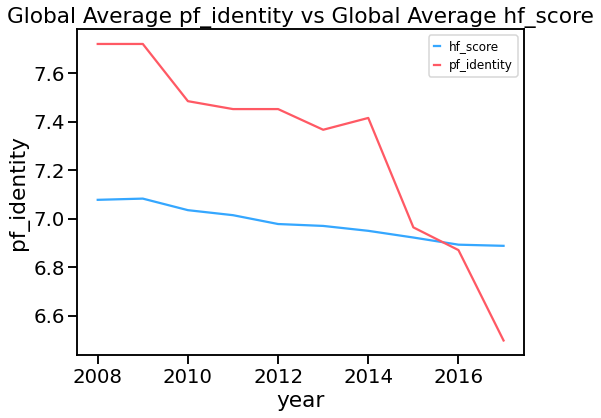

In [19]:
data_ = dataset_base.groupby("year").mean().reset_index()
plt.figure(figsize=(8, 6))
ax = seaborn.lineplot(x="year", y="hf_score", data=data_,color=BLUE)
bx = seaborn.lineplot(x="year", y="pf_identity",data=data_,color=RED)
legend = ax.legend(labels=['hf_score','pf_identity'],handlelength=.5,fontsize=12)
ax.set(xlabel='year',title="Global Average pf_identity vs Global Average hf_score")

2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?


Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

<Figure size 1800x1440 with 0 Axes>

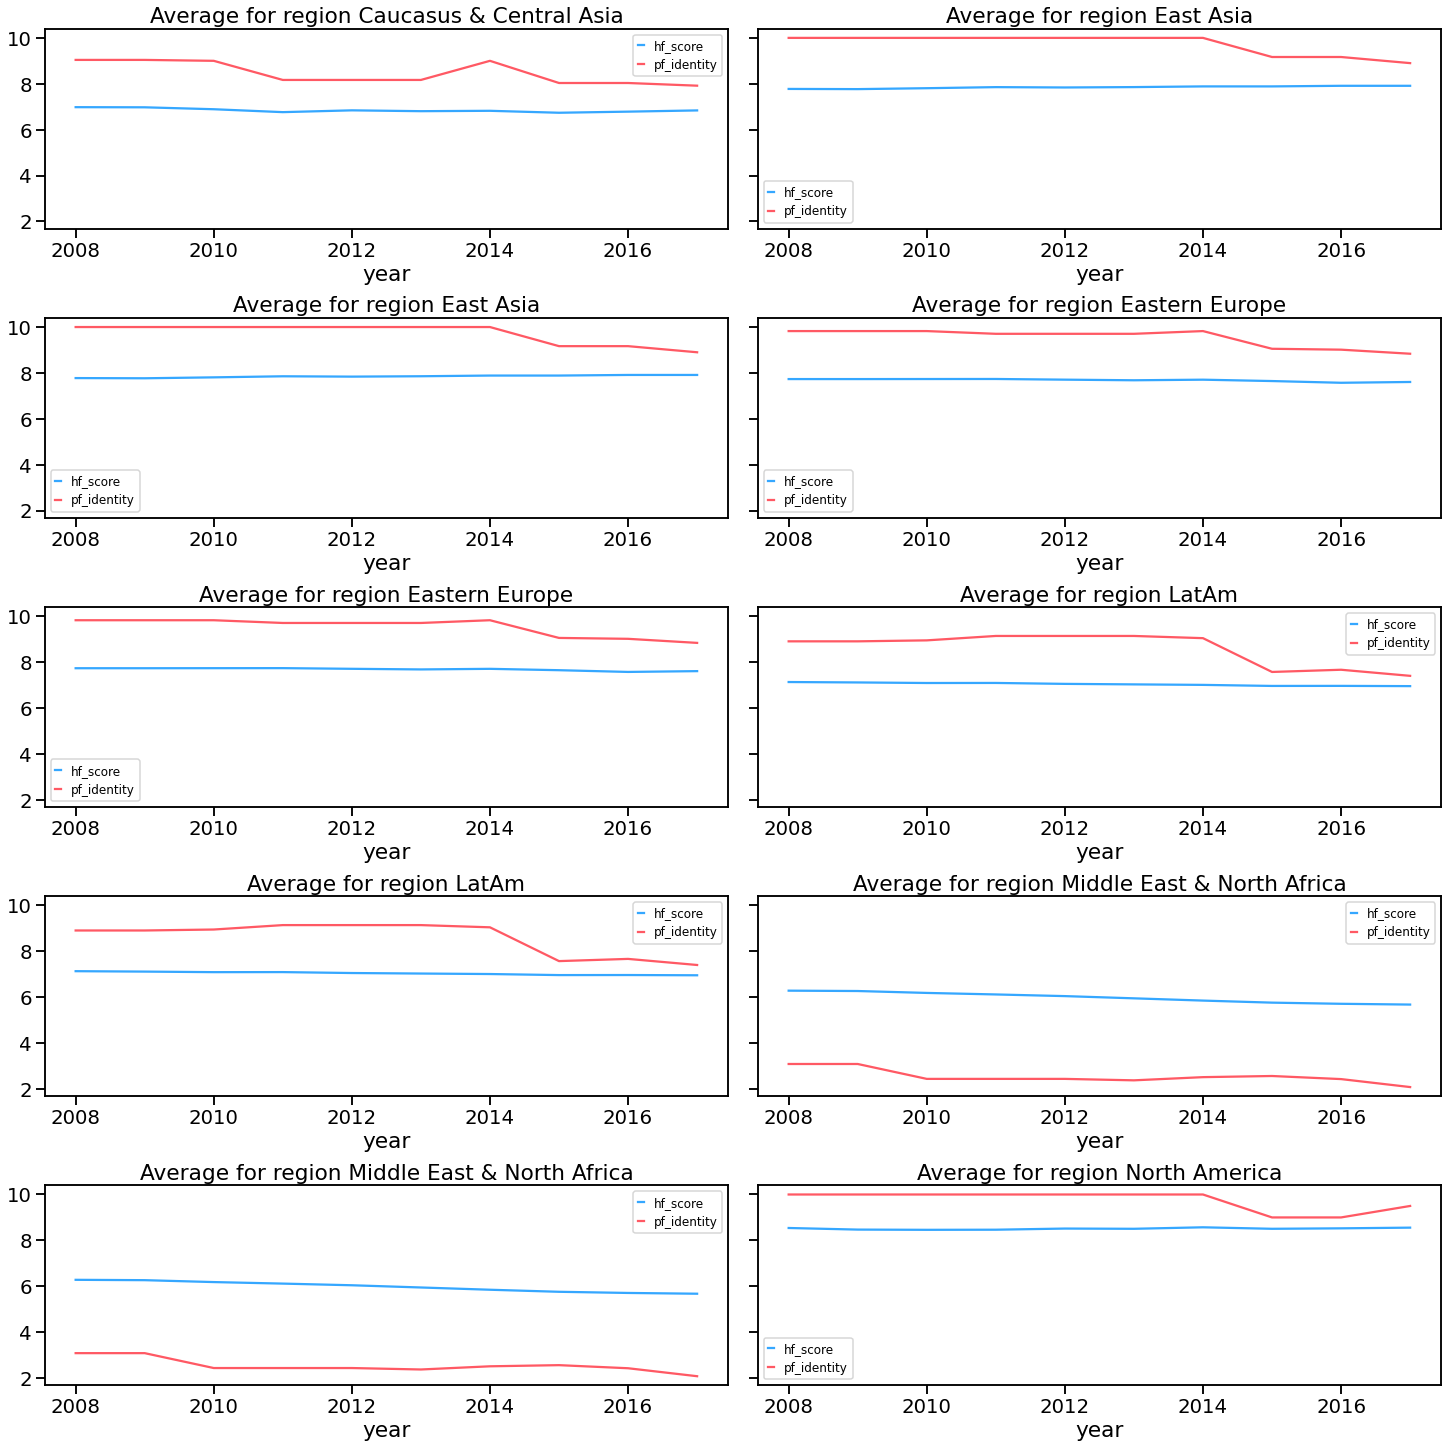

In [20]:
data_ = dataset_base.groupby(["year","region"]).mean().reset_index()
regions = data_.loc[:,"region"].drop_duplicates()
def region_dfs_with_hf_pf(region,):
    region_raw = data_[data_.region==region]
    region_df = pandas.concat([pandas.DataFrame(region_raw.loc[:,'year']),pandas.DataFrame(region_raw.loc[:,'pf_identity'])],axis=1)
    region_df["hf_score"] =region_raw.loc[:,'hf_score']
    region_df
    return region_df
def plot_for_regions(regions):
    columns = list(range(2))
    rows = list(range(len(regions) // len(columns)))
    for i in rows:
        for j in columns:
            seaborn.lineplot(x="year", y="hf_score",data=region_dfs_with_hf_pf(regions[i+j]),ax=ax[i,j], color=BLUE)
            seaborn.lineplot(x="year", y="pf_identity",data=region_dfs_with_hf_pf(regions[i+j]), ax=ax[i,j],color=RED)
            ax[i,j].set(ylabel=None, xlabel='year', title="Average for region "+regions[i+j])
            ax[i,j].legend(labels=[ 'hf_score','pf_identity'],handlelength=.5,fontsize=12)
            
plt.figure(figsize=(25, 20))
fig, ax =plt.subplots(5,2,constrained_layout=True, figsize=(20,20),sharey=True)
plot_for_regions(regions)

Teniendo en cuenta lo que vemos en los gráficos por región vs el gráfico de tendencias global vemos que si bien no todas las regiones en particular decrecen como la pendiente de la tendencia global indica, **la gran mayoría sí decrece**.

Veamos ahora la relación hf_score con ef_score

<Figure size 1800x1440 with 0 Axes>

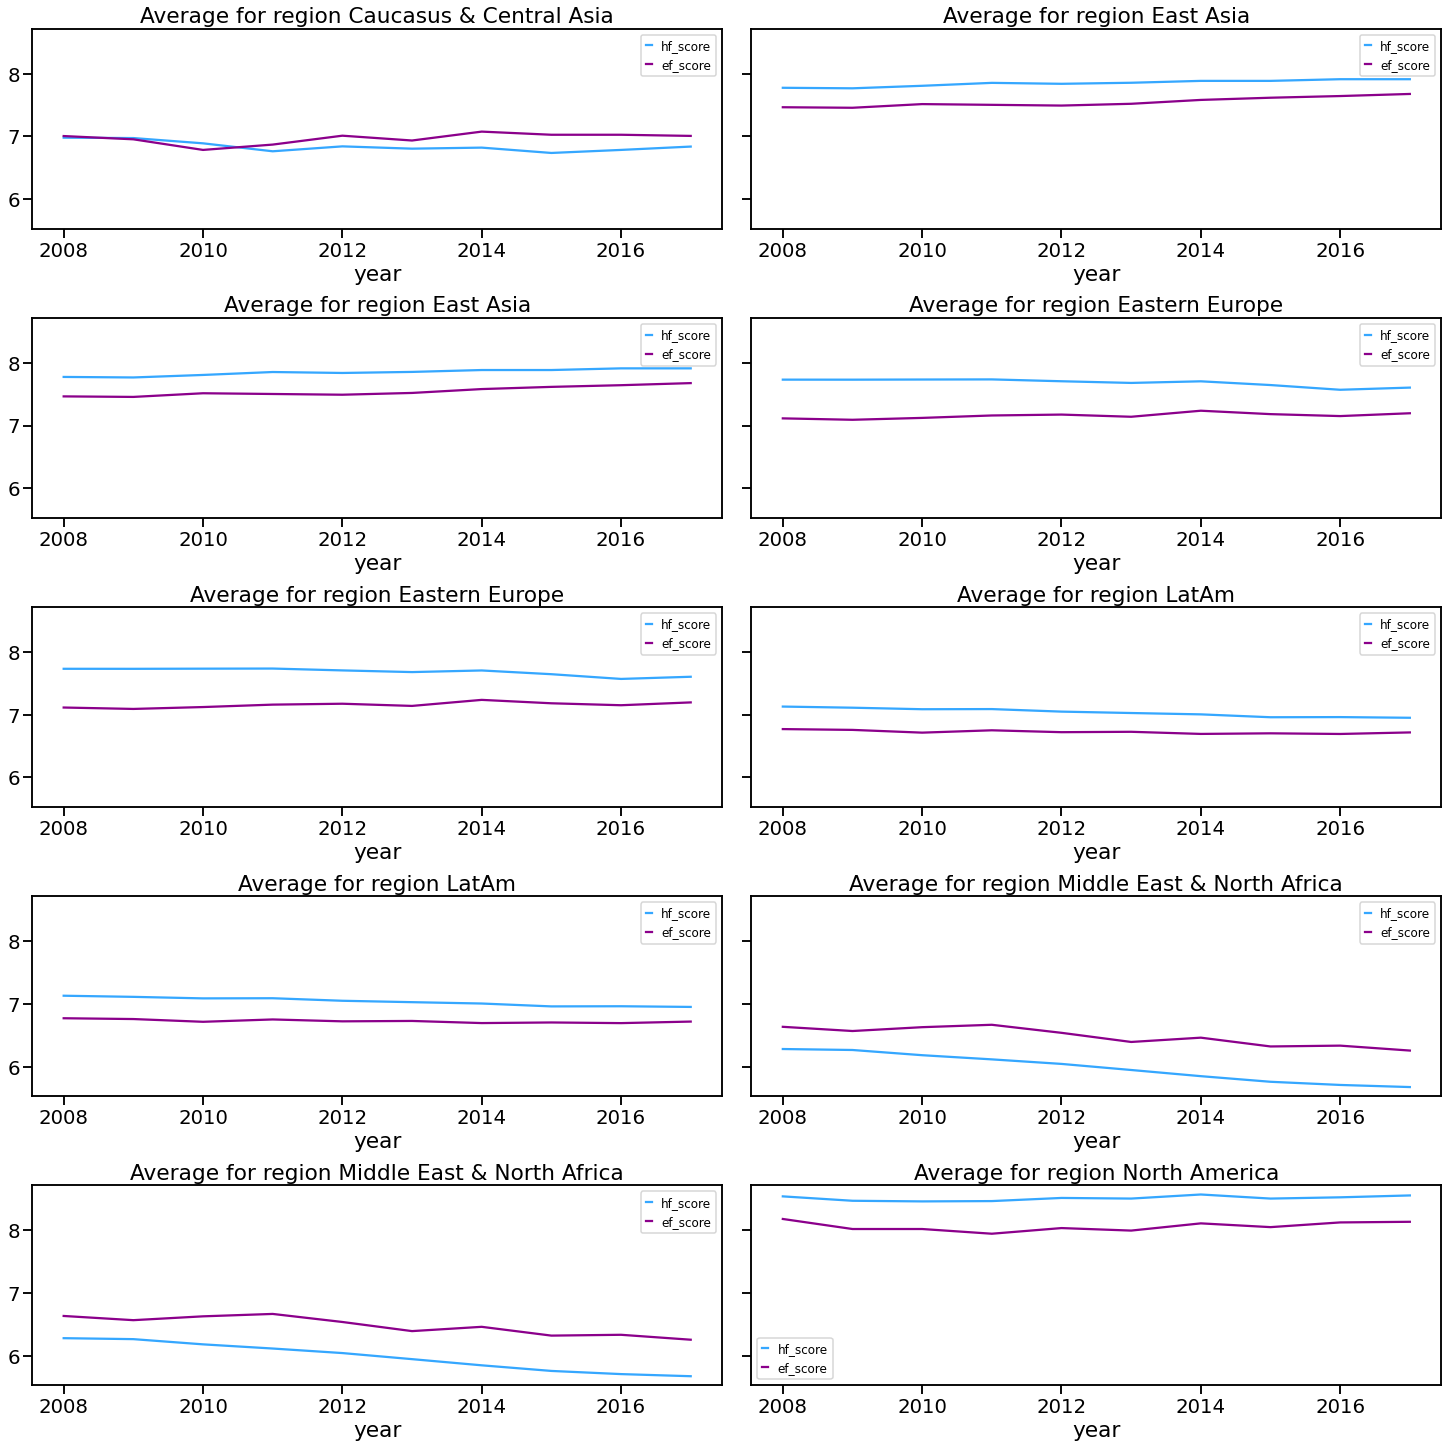

In [21]:
data_ = dataset_base.groupby(["year","region"]).mean().reset_index()
regions = data_.loc[:,"region"].drop_duplicates()

def region_dfs_with_hf_ef(region):
    region_raw = data_[data_.region==region]
    region_df = pandas.concat([pandas.DataFrame(region_raw.loc[:,'year']),pandas.DataFrame(region_raw.loc[:,'ef_score'])],axis=1)
    region_df["hf_score"] =region_raw.loc[:,'hf_score']
    region_df
    return region_df
def plot_for_regions_hf_ef(regions):
    columns = list(range(2))
    rows = list(range(len(regions) // len(columns)))
    for i in rows:
        for j in columns:
            seaborn.lineplot(x="year", y="hf_score",data=region_dfs_with_hf_ef(regions[i+j]),ax=ax[i,j], color=BLUE)
            seaborn.lineplot(x="year", y="ef_score",data=region_dfs_with_hf_ef(regions[i+j]), ax=ax[i,j],color="darkmagenta")
            ax[i,j].set(ylabel=None, xlabel='year', title="Average for region "+regions[i+j])
            ax[i,j].legend(labels=['hf_score','ef_score'],handlelength=.5,fontsize=12)

plt.figure(figsize=(25, 20))
fig, ax =plt.subplots(5,2,constrained_layout=True, figsize=(20,20),sharey=True)
plot_for_regions_hf_ef(regions)


En los gráficos se puede ver que ambas ef_score y hf_score suelen crecer/decrecer juntas. Por su similitud en el comportamiento, pareciera ser que están correlacionadas de alguna forma. Sabiendo que hf_score se compone de otros scores, surge como posible hipótesis que ef_score es una de las métricas de las que se deriva hf_score.

3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. 
¿Cómo seleccionarion los países relevantes a esa tendencia?

Elegimos analizar Venezuela, Chile, Brazil, Argentina. Por ser habitantes de Latinoamérica sabemos que este grupo presenta un gran rango de situaciones. 

Text(0.5, 0.98, 'Mean scores LatAm')

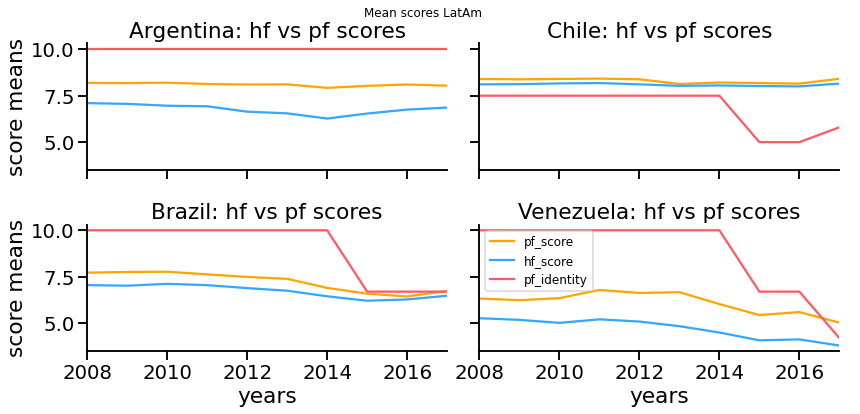

In [22]:
countries = ['Argentina','Chile', 'Brazil', 'Venezuela']
g = seaborn.FacetGrid(dataset_base, col="countries",
                      margin_titles=True, aspect=2, col_wrap=2,
                      col_order=countries)
g=g.map(seaborn.lineplot, "year", "pf_score", color="orange").add_legend();
g = (g.map(seaborn.lineplot, "year", "hf_score", color=BLUE))
g = (g.map(seaborn.lineplot, "year", "pf_identity", color=RED))

g.set(xlim=(2008, 2017),)
g.set_titles("{col_name}: hf vs pf scores")
g.set_axis_labels("years", "score means")
plt.xlabel("years")
plt.legend(["pf_score","hf_score","pf_identity"], fontsize=12)
g.fig.suptitle("Mean scores LatAm",fontsize=12)

LatAm como región tiene un cambio de pendiente de pf_identity muy pronunciado en 2014. Analizando los países que elegimos podemos ver que esto es algo que se observa en la mayoría de los países elegidos. Podemos concluir que este cambio de pendiente se debe a esto; hubo un cambio generalizado en la región en ese año que llevó a esto.

## 3. Distribuciones 
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todo el conjunto de valores disponibles para esa region en estos gráficos?


No es correcto utilizar todo el conjunto de valores disponibles para la región de LatAm, ya que los datos de distintos años son independientes. En vez de eso elegimos graficar los datos de un año, el 2017.

Text(0.5, 1.0, 'Distribución la variable identidad en Latinoamérica y Caribe')

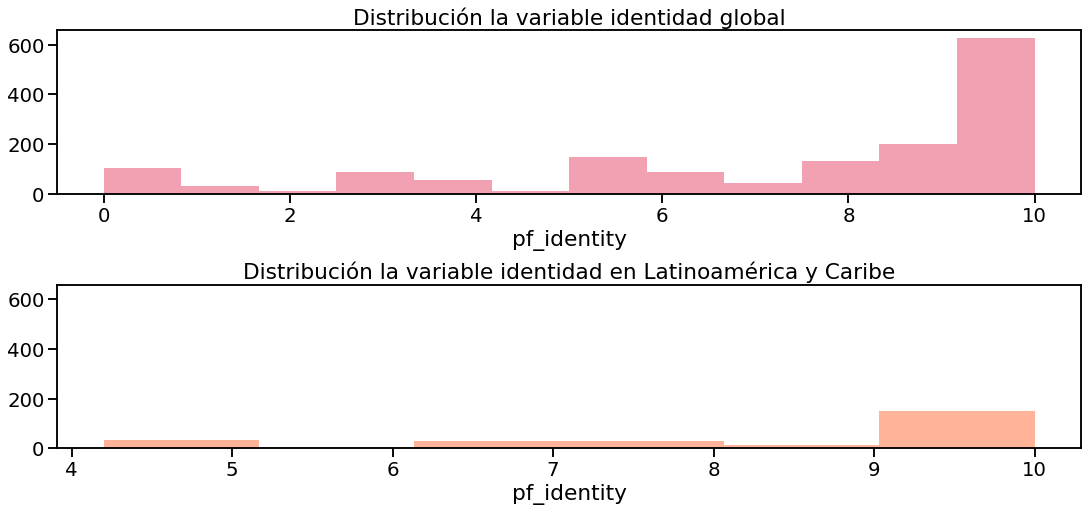

In [23]:
latam = dataset_base.groupby(['region']).get_group('LatAm')
fig, ax =plt.subplots(2,1,constrained_layout=True, figsize=(15,7),sharey=True)
g=seaborn.distplot(dataset_base.pf_identity,kde=False, ax=ax[0], color="crimson")
g.set_title("Distribución la variable identidad global")
g =seaborn.distplot(latam.pf_identity, kde=False,ax=ax[1], color="orangered")
g.set_title("Distribución la variable identidad en Latinoamérica y Caribe")

pf_identity pareciera tener distribución exponencial.
La muestra está concentrada hacia la derecha, es decir, hay una probabilidad más alta, dada una muestra, de encontrarse con una pf_identity con valor alto.

Text(0.5, 1.0, 'Distribución la variable Human Freedom en Latinoamérica y Caribe')

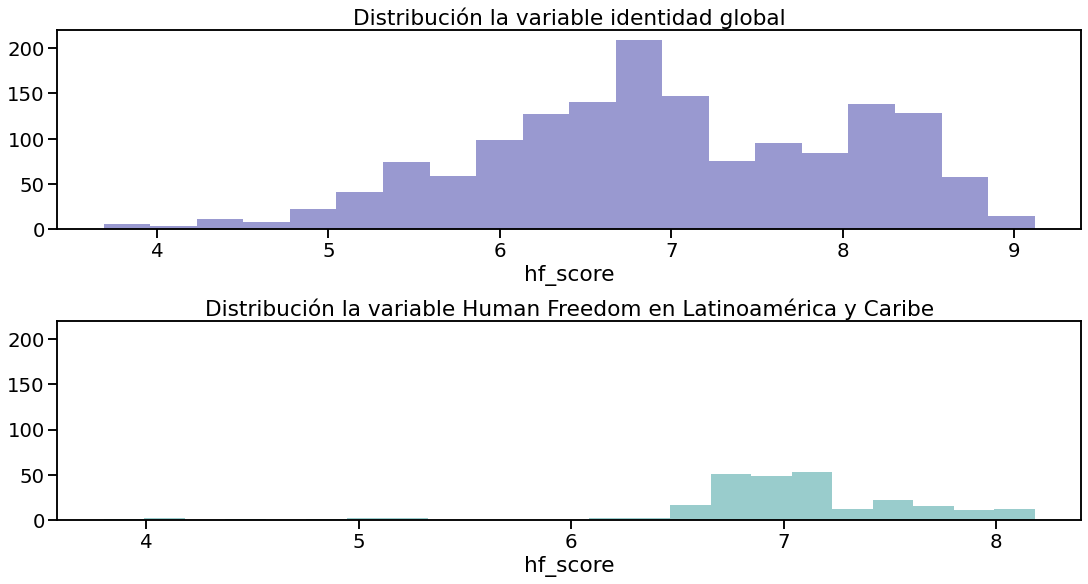

In [24]:
latam = dataset_base.groupby(['region']).get_group('LatAm')
fig, ax =plt.subplots(2,1,constrained_layout=True, figsize=(15,8),sharey=True)
g=seaborn.distplot(dataset_base.hf_score,kde=False, ax=ax[0], color="darkblue")
g.set_title("Distribución la variable identidad global")
g =seaborn.distplot(latam.hf_score, kde=False,ax=ax[1], color="teal")
g.set_title("Distribución la variable Human Freedom en Latinoamérica y Caribe")

hf_score pareciera tener distribución Normal/Chi cuadrado.
La distribución de hf_score global presenta dos copas, un máximo global y uno local.
La muestra está concentrada levemente hacia la derecha, el máximo global se da para un hf_score de aprox 7,
siendo el otro pico alrededor del hf_score aprox 8.

La distribución de hf_score en Latam está más concentrada a la derecha, es decir, respecto al hf_score global, es más probable, dada una muestra random de LatAm que esta misma tenga un hf_score más alto que la global.

## 4. Correlaciones y Relaciones -  Gonzalo

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_indentity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.
3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.
4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.



Text(0.5, 1.08, 'Correlación entre variables. Año 2017.')

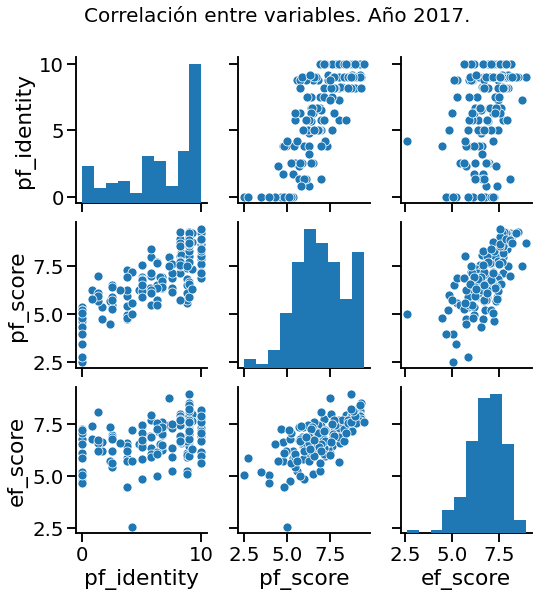

In [25]:
# Realizamos los gráficos para un año particular ya que el dataset completo es muy denso
datos1=dataset_base[dataset_base.year==2017]
columnasimpor=['pf_identity','pf_score','ef_score']
datos=datos1[columnasimpor]
m = seaborn.pairplot(datos);
m.fig.suptitle('Correlación entre variables. Año 2017.', fontsize=20, y=1.08)

Los conjuntos de datos están relacionados de manera positiva entre ellos, lo cual era esperable en una primera instancia para los valores de  pf_score y pf_identity, ya la primera es calculada a partir de la segunda. Se observa además que el indicador de libertad económica (ef_score) se vincula de manera positiva con el indicador de libertad personal (pareciese ser una relación bastante fuerte), que es lo esperable por los autores del informe. No pareciese, al menos visualmente, que la liberar económica tuviese una vinculación fuerte con el indicador de liberar de identidad(pf_identity).
La utilización de este tipo de gráficos en variables como pf_identity es discutible, dado que los puntajes que pueden obtener las variables que lo componen están acotados a un número finito de valores (en general no más de 3), con lo cual existe una cantidad finita de resultados posibles para pf_identity, por lo que quizas un gráfico de barras sería más adecuado para definir las categorías.

Text(0.6, 1.05, 'Correlación entre variables. Año 2017')

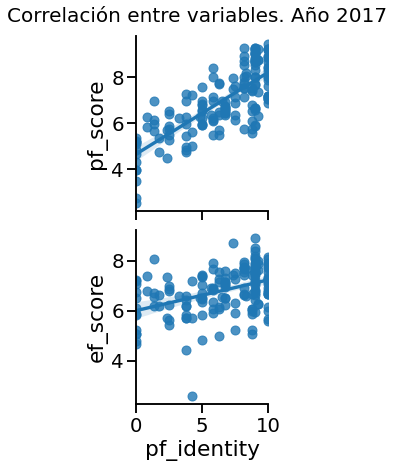

In [26]:
#Graficamos las dos relaciones en el mismo grafico para facilitar la visualización.
g = seaborn.PairGrid(datos, x_vars=["pf_identity"], y_vars=["pf_score", "ef_score"], height=3)
g.map(seaborn.regplot)
g.fig.suptitle('Correlación entre variables. Año 2017', fontsize=20, y=1.05, x=0.6)
# Para pf_identity vs pf_score se podría utilizar una regresión logística?

En primera instancia se observa que existe una relación positiva entre pf_identity y pf_score, que es lo esperado dado que es un componente del indice, como se mencionó anteriormente. Con respecto a la ef_score, si bien la función genera una linea de regresión con pendiente positiva, visualmente no parecieran tener una gran asociación entre los conjuntos. Probablemente excluyendo algunos valores extremos la recta de regresión sería anulada. Un análisis más pronfundo requeriría la utilización de algún indicador de la bondad del ajuste de la regresión.
Sacar conclusiones a partir de este tipo de análisis entendemos no sería lo más adecuado en vista que el tipo de relación que existe entre las variables no sería lineal si no probablemente del tipo logística. 

Tenemos que decidir si vamos a trabaja con todos los datos en esta sección o solo con un año (en la anterior se utilizó solo un año y no ser consistentes en la metodología de análisis es incorrecto). Utilizando todos los datos encuentro compleja la visualización de todas las relaciones por que los mapas de calor no son claros.
Al momento de realizar la división de según categorías la elección que tomamos fue agrupar utilizando los cuartiles, encontrandonos con un inconveniente en lo referente a la variable pf_identity. Dado que la misma no es una variable continua si no discreta, el tercer y cuarto cuartil son coincidentes. (esto es posible?). por lo que tuvimos que realizar la agrupación con las siguientes cotas: low= 0,25, medium: 0,5, hig: 1. Esto puede estar generando inconvenientes con la separación en los conjuntos con más continuidad en los valores.

In [27]:
#calculamos el pf_score_segment para el año 2017

quartiles_pf = dataset_base.pf_score.quantile([0,0.25,0.5,0.75,1]).round(2)
quartiles_pf = quartiles_pf.tolist()
pf_score_segment = pandas.cut(x=datos['pf_score'], bins=[quartiles_pf[0], quartiles_pf[1],quartiles_pf[2],quartiles_pf[4]], labels=["low","medium","high"], include_lowest=True)
print(pf_score_segment)

#calculamos el ef_score_segment para el año 2017

quartiles_ef = dataset_base.ef_score.quantile([0,0.25,0.5,0.75,1]).round(2)
quartiles_ef = quartiles_ef.tolist()
ef_score_segment = pandas.cut(x=datos['ef_score'], bins=[quartiles_ef[0], quartiles_ef[1],quartiles_ef[2],quartiles_ef[4]], labels=["low","medium","high"], include_lowest=True)
print(ef_score_segment)

#calculamos el pf_identity_segment para el año 2017

quartiles_pfid = dataset_base.pf_identity.quantile([0,0.25,0.5,0.75,1]).round(2)
quartiles_pfid = quartiles_pfid.tolist()
pf_identity_segment = pandas.cut(x=datos['pf_identity'], bins=[quartiles_pfid[0], quartiles_pfid[1],quartiles_pfid[2],quartiles_pfid[4]], labels=["low","medium","high"], include_lowest=True)
print(pf_identity_segment)

0        high
1         low
2         low
3        high
4        high
5        high
6        high
7         low
8        high
9         low
10        low
11       high
12     medium
13       high
14     medium
15       high
16     medium
17     medium
18       high
19     medium
20     medium
21        low
22       high
23       high
24        low
25     medium
26        low
27       high
28       high
29        low
        ...  
132      high
133      high
134      high
135      high
136    medium
137       low
138      high
139      high
140      high
141       low
142      high
143       low
144       low
145    medium
146      high
147    medium
148    medium
149       low
150       low
151       low
152    medium
153       low
154      high
155      high
156      high
157       low
158    medium
159       low
160       low
161       low
Name: pf_score, Length: 162, dtype: category
Categories (3, object): [low < medium < high]
0        high
1         low
2         low
3         low

Text(54.5, 0.5, 'Libertad Personal')

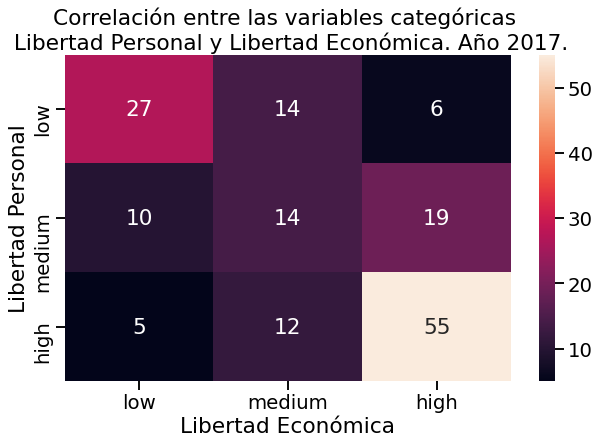

In [28]:
#Correlación visual entre pf_score_segment y ef_score_segment
plt.figure(figsize=(10,6))
exp = pandas.crosstab(pf_score_segment, ef_score_segment)
seaborn.heatmap(exp, annot=True)
plt.title("Correlación entre las variables categóricas \n Libertad Personal y Libertad Económica. Año 2017.")
plt.xlabel("Libertad Económica")
plt.ylabel("Libertad Personal")

Text(54.5, 0.5, 'Libertad Económica')

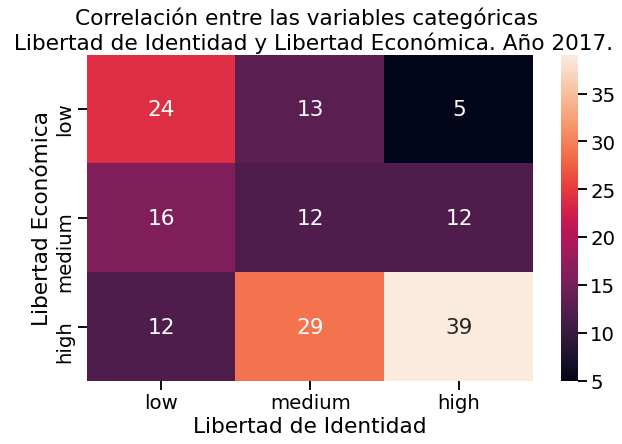

In [29]:
#Correlación visual entre pf_identity_segment y ef_score_segment
plt.figure(figsize=(10,6))
exp = pandas.crosstab(ef_score_segment, pf_identity_segment)
seaborn.heatmap(exp, annot=True)
plt.title("Correlación entre las variables categóricas \n Libertad de Identidad y Libertad Económica. Año 2017.")
plt.xlabel("Libertad de Identidad")
plt.ylabel("Libertad Económica")

Text(54.5, 0.5, 'Libertad Personal')

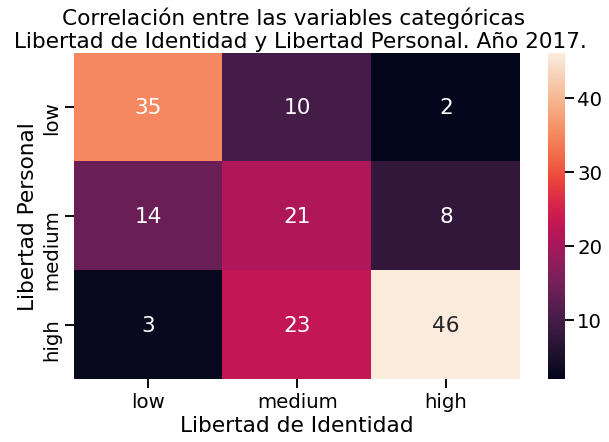

In [30]:
#Correlación visual entre pf_identity_segment y pf_score_segment
plt.figure(figsize=(10,6))
exp = pandas.crosstab(pf_score_segment, pf_identity_segment)
seaborn.heatmap(exp, annot=True)
plt.title("Correlación entre las variables categóricas \n Libertad de Identidad y Libertad Personal. Año 2017.")
plt.xlabel("Libertad de Identidad")
plt.ylabel("Libertad Personal")

# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

## 3. Distribuciones

2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

In [31]:
data_2017 = dataset_base.groupby("year").get_group(2017)
latam = data_2017.groupby(['region']).get_group('LatAm')
z = latam.hf_score.to_numpy()
z = z.tolist()
w = latam.pf_identity.to_numpy()
w = w.tolist()
hf_scores=[score for score in z if str(score) != 'nan']
x_hf = scipy.stats.kstest(hf_scores,"norm")

pf_identities=[score for score in w if str(score) != 'nan']
x_pf = scipy.stats.kstest(pf_identities,"norm")

print("hf_score: ", x_hf)
print("pf_identity: ", x_pf)

hf_score:  KstestResult(statistic=0.9999276519560749, pvalue=4.4271743843264904e-108)
pf_identity:  KstestResult(statistic=0.9999866542509841, pvalue=3.6303356195128583e-127)


**La distribucion no es normal porque comparando ambas distribuciones usando el ktest nos encontramos con que se diferencian mucho (lo podemos ver por el   valor alto del D - distancia). Teniendo en cuenta el p-value, al ser tan chico rechazamos H0 que nos dice que ambas distr se parecen.**

## 4. Correlaciones

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 


In [32]:
#Calculamos el coeficiente de correlación entre las variables pf_identity y pf_score. Año 2017.

coef, p = spearmanr(datos.pf_identity, datos.pf_score)
print('Coeficiente de correlación de Spearman: %.3f' % coef)

# interpretamos el nivel de significación

alpha = 0.05
if p > alpha:
    print('Las variables no están correlacionadas (no puede rechazar H0) p=%.3f' % p)
else:
    print('Las variables están correlacionadas (rechazar H0) p=%.3f' % p)

Coeficiente de correlación de Spearman: 0.759
Las variables están correlacionadas (rechazar H0) p=0.000


Se puede decir que las variables estaríamos en lo correcto al afirmar la proposición de que pf_identity y pf_score están fuertemente relacionadas. Esto puede deducirse por el hecho de que el coeficiente de Spearman entre estas dos variables es de 0.759, lo que muestra existe una correlación positiva y cercana a 1. 
Además, a través de una prueba de hipótesis existe evidencia estadistica para rechazar la independencia de las variables, dado que el p valor es menor al alfa definido (0.05).

In [33]:
#Calculamos el coeficiente de correlación entre las variables pf_identity y ef_score. Año 2017.

from scipy.stats import spearmanr 
coef, p = spearmanr(datos.pf_identity, datos.ef_score)
print('Coeficiente de correlación de Spearman: %.3f' % coef)

# interpretamos el nivel de significación }

alpha = 0.05
if p > alpha:
    print('Las variables no están correlacionadas (no puede rechazar H0) p=%.3f' % p)
else:
    print('Las variables están correlacionadas (rechazar H0) p=%.3f' % p)

Coeficiente de correlación de Spearman: 0.422
Las variables están correlacionadas (rechazar H0) p=0.000


Se puede decir que las variables estaríamos en lo correcto al afirmar la proposición de que pf_identity y ef_score están relacionadas. Esto puede deducirse por el hecho de que el coeficiente de Spearman entre estas dos variables es de 0.422, lo que muestra existe una correlación positiva, pero no tan cercana a 1. 
Además, a través de una prueba de hipótesis existe evidencia estadistica para rechazar la independencia de las variables, dado que el p valor es menor al alfa definido (0.05).

4. [Opcional] Analizar la correlación entre la region y el pf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros). Genere nuevas variables categóricas ordinales para calcular la correlación Tau de Kendal y genere una tabla de contingencia con esas nuevas variables.

In [34]:
datos2 = datos1.assign(pf_identity_segment = pf_identity_segment, pf_score_segment = pf_score_segment, ef_score_segment = ef_score_segment)
datos2.head()

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,pf_identity_segment,pf_score_segment,ef_score_segment
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0,medium,high,high
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0,low,low,low
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0,low,low,low
3,2017,ARG,Argentina,LatAm,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0,high,high,low
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0,medium,high,high


In [35]:
#Elaboramos la tabla de contingencia entre la variable pf_score_segment y region. Año 2017.

exp1 = pandas.crosstab(datos2.region, datos2.pf_score_segment)
exp1

pf_score_segment,low,medium,high
region,,,
Caucasus & Central Asia,2,2,2
East Asia,1,0,5
Eastern Europe,1,2,19
LatAm,1,12,13
Middle East & North Africa,16,2,1
North America,0,0,2
Oceania,0,1,3
South Asia,6,9,2
Sub-Saharan Africa,20,15,7


In [36]:
#Hacemos el test chi2_contingency para probar la independencia entre las variables pf_score_segment y region.

from scipy.stats import chi2_contingency
g, p, dof, expctd = chi2_contingency(exp1)
g, p

# interpretamos el nivel de significación 

alpha = 0.05
if p > alpha:
    print('Las variables no están correlacionadas (no puede rechazar H0) p=%.3f' % p)
else:
    print('Las variables están correlacionadas (rechazar H0) p=%.3f' % p)

Las variables están correlacionadas (rechazar H0) p=0.000


In [37]:
#Elaboramos la tabla de contingencia entre la variable ef_score_segment y region. Año 2017.

exp2 = pandas.crosstab(datos2.region, datos2.ef_score_segment)
exp2

ef_score_segment,low,medium,high
region,,,
Caucasus & Central Asia,1,1,4
East Asia,0,1,5
Eastern Europe,1,6,15
LatAm,3,9,14
Middle East & North Africa,8,5,6
North America,0,0,2
Oceania,0,2,2
South Asia,4,7,6
Sub-Saharan Africa,25,9,8


In [38]:
#Hacemos el test chi2_contingency para probar la independencia entre las variables ef_score_segment y region.

from scipy.stats import chi2_contingency
g, p, dof, expctd = chi2_contingency(exp2)
g, p

# interpretamos el nivel de significación 

alpha = 0.05
if p > alpha:
    print('Las variables no están correlacionadas (no puede rechazar H0) p=%.3f' % p)
else:
    print('Las variables están correlacionadas (rechazar H0) p=%.3f' % p)

Las variables están correlacionadas (rechazar H0) p=0.000


In [39]:
#Elaboramos la tabla de contingencia entre la variable pf_identity_segment y region. Año 2017.

exp3 = pandas.crosstab(datos2.region, datos2.pf_identity_segment)
exp3

pf_identity_segment,low,medium,high
region,,,
Caucasus & Central Asia,0,4,2
East Asia,0,2,4
Eastern Europe,0,7,15
LatAm,5,12,9
Middle East & North Africa,17,2,0
North America,0,0,2
Oceania,1,0,3
South Asia,6,10,1
Sub-Saharan Africa,23,16,3


In [40]:
#Hacemos el test chi2_contingency para probar la independencia entre las variables ef_score_segment y region.

g, p, dof, expctd = chi2_contingency(exp3)
g, p

# interpretamos el nivel de significación 

alpha = 0.05
if p > alpha:
    print('Las variables no están correlacionadas (no puede rechazar H0) p=%.3f' % p)
else:
    print('Las variables están correlacionadas (rechazar H0) p=%.3f' % p)

Las variables están correlacionadas (rechazar H0) p=0.000


En los tres casos analizados, a través del test chi-cuadrado para tablas de contingencia, encontramos evidencia para rechazar la hipótesis nula de independencia de variables, dado que el p-valor es menor al alfa definido (0,05).

Además de completar estos puntos faltantes, luego de haber visitado los conceptos de percepción visual y comunicación efectiva, están en condiciones de reveer los gráficos realizados y evaluar si pueden ser mejorados. Para ello, puede hacerse las siguientes preguntas:

* ¿Están utilizando el tipo de gráfico adecuado para cada tipo de variable?
* Los gráficos, ¿son legibles?
* Los gráficos generados, ¿responden a las preguntas mostrando un patrón claro? En caso de que no, ¿podemos filtrar los datos para que el patrón sea más evidente? ¿o agruparlos de manera distinta? ¿o cambiar el tipo de gráfico?